# Pretrained GAN

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Crappified data

In [3]:
from crappify import *

In [4]:
# il = ImageList.from_folder(path_hr)
# parallel(crappifier(path_lr, path_hr), il.items)

In [6]:
bs, size = 32, 128
# bs, size = 24, 160
# bs, size = 8, 256

arch = models.resnet34

## Pre-train generator

In [7]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [8]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True)
           )
    data.c = 3
    return data

In [9]:
data_gen = get_data(bs, size)

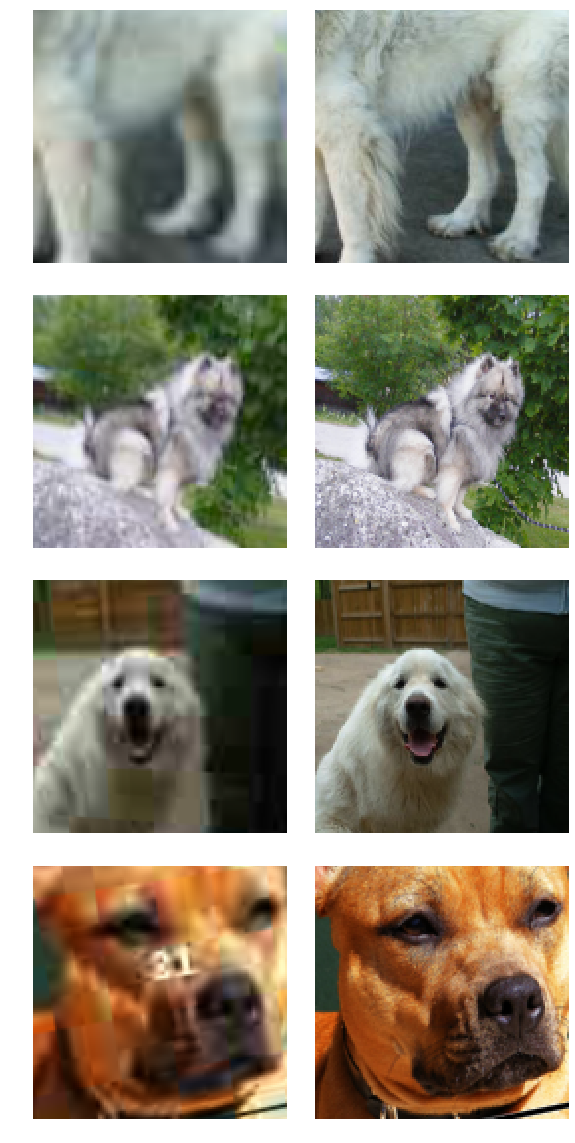

In [10]:
data_gen.show_batch(4)

In [11]:
wd = 1e-3

In [12]:
y_range = (-3., 3.)

In [13]:
loss_gen = MSELossFlat()

In [18]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight, 
                      self_attention=True, y_range=y_range, loss_func=loss_gen) 

In [19]:
learn_gen = create_gen_learner()

In [20]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connecti

KeyboardInterrupt: 

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn.fit_one_cycle(3, slice(1e-6, 1e-3))

In [ ]:
learn_gen.show_results(rows=4)

In [ ]:
learn_gen.save('gen-pre2')

## Save generated images

In [ ]:
learn_gen.load('gen-pre2')

In [ ]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
# shutil.rmtree(path_gen)

In [ ]:
path_gen.mkdir(exist_ok=True)

In [ ]:
def save_preds(dl):
    i = 0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [ ]:
save_preds(data_gen.fix_dl)

In [ ]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [ ]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [ ]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

In [ ]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [ ]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [ ]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3)

In [ ]:
learn_critic.save('critic-pre2')

## GAN

In [ ]:
learn_crit = None
learn_gen = None
gc.collect()

In [ ]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [ ]:
learn_crit = create_critic_learner(data_crit, metrics=None).lead('critic-pre2')

In [ ]:
learn_gen = create_gen_learner().load('gen-pre2')

### Switcher

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1., 50.), show_img=False, switcher=switcher, 
                                opt_func=partial(optim.Adam, betas=(0., 0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, multi_lr=5.))

In [ ]:
lr = 1e-4

In [ ]:
learn.fit(40, lr)

In [ ]:
learn.save('gan-1c')

In [ ]:
learn.data=get_data(16, 192)

In [ ]:
learn.fit(10, lr/2)

In [ ]:
learn.show_results(rows=16)

In [ ]:
learn.save('gan-1c')